# Optimización del Uso de Bodega de Equipaje

## Parte I – Propuesta conceptual

1. Datos necesarios

El objetivo es maximizar el uso de la bodega de equipaje, por lo que se requiere de distintos datos para una optima solución, como información del vuelo, pasajeros, equipaje y restricciones. Las variables a utilizar sobre el vuelo son id de vuelo, origen, destino, fecha, horario de salida, tipo de avion, capacidad máxima de bodega respecto al peso y capacidad máxima de bodega respecto al volumen, número de asientos para los pasajeros.
Para la variable de pasajeron se requiero un id del pasajero, id del vuelo, clase, número de maletas bodega y confirmación del check-in.
las variables para el equipaje serían el id de equipaje, id pasajero, id de vuelo, peso(kg), volumen(m3) y maleta confirmada dado check-in.

Estos datos permiten construir un algoritmo de optimización que decida qué equipaje aceptar o rechazar según restricciones. Además, facilitan la priorización por clase y el aprovechamiento eficiente de la bodega, reduciendo riesgos de sobrecarga y evitando espacio desaprovechado.

2. Evaluación de pertinencia y calidad

Para asegurar que los datos sean útiles y confiables, consideraría la relevancia del dato, es decir debe estar directamente relacionado con el uso de la bodega, además de la precisión y exactitud, así evitar errores de medición en peso/volumen y que no existan valores faltantes en variables críticas como peso del equipaje o capacidad de bodega, otro criterios sería que los datos deben estar disponibles al menos 4 horas antes del vuelo, para garantizar tiempo suficiente en la toma de decisiones.


3. Desarrollo de la solución


Para desarrollar la solución, se requiere generar los datos para vuelo, pasajeros, equipaje, donde para cada dataset se le incluira restricciones operativas. En un entorno real, se incluiría un proceso de limpieza y control de calidad. Lo siguiente es desarrollar un algoritmo que tenga la capacidad de optimizar la bodega de equipaje, para decidir que maletas entran o no en el avión, para ello se tendrá en cuenta incluyir maletas obligatorias (primera maleta para usuarios que realizen check-in), luego ordena el resto por prioridad (PremiumEconomy primero, luego Economy) e intenta asignarlas verificando peso y volumen, lo que no entra se rechaza o se reintenta en vuelos posteriores. Finalmente, generar dashboards o reportes automáticos que muestren capacidad total, equipaje esperado, porcentaje de uso de la bodega y riesgos de sobrecarga.

En este prototipo, la variable baggage_confirmed representa el equipaje confirmado al menos 4 horas antes del vuelo para asegurar que los resultados estén disponibles 4 horas antes del vuelo. En un entorno real, se requiere una ventana de corte de 4 horas antes para confirmar el equipaje confirmado, se implementaría un modelo predictivo y notificaciones automáticas al área de operaciones si la proyección muestra sobrecarga o espacio desaprovechado significativo.



## Parte II – Prototipo con datos sintéticos

In [1]:
#Librerías
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

#Semilla
rng = np.random.default_rng(123)

1) Generación de datos sintéticos

In [2]:
#Definir flotas y capacidad de bodega y personas (inspirado en información de LATAM, valores aproximados)
# De esta forma, en primera instancia incluimos limitaciones de peso/volumen en la bodega
fleet_info = {
    "A320": {"cap_weight_kg": 3900, "cap_vol_m3": 27.5, "n_seats": 170},
    "B777": {"cap_weight_kg": 22000, "cap_vol_m3": 51.2, "n_seats": 400}
}

######
###### Definir vuelos del día
######

# Para la propuesta se simulan los vuelos para el 17/09/2025
# las rutas de vuelo son Valparaíso - Antofagasta y Valparaíso - Pto. Montt
# cada ruta tendrá 5 vuelos separados por 4 horas
routes = [("VAP", "ANF"), ("VAL", "PMT")]
date = datetime(2025, 9, 17)

flights = []
fid = 1
for route in routes:
    for i in range(5): # n° de rutas
        ac = "B777" if fid % 2 == 0 else "A320" # alternar flota
        flights.append({
            "flight_id": f"VF{fid:03d}",
            "origin": route[0],
            "destination": route[1],
            "datetime": date + timedelta(hours=4*i), #vuelos sep cada 4h
            "aircraft": ac,
            "cap_weight_kg": fleet_info[ac]["cap_weight_kg"],
            "cap_vol_m3": fleet_info[ac]["cap_vol_m3"],
            "n_seats": fleet_info[ac]["n_seats"]
        })
        fid += 1

df_flights = pd.DataFrame(flights)

######
###### Definir pasajeros y equipaje
######

# Para los pasajeros consideraremos que la ocupación del avión, dada la fecha, irá entre el 90% a 100% de ocupación
# las clases son Premium Economy y Economy, donde el 80% es Economy y 20% PremiumEconomy
# respecto al el n° de equipaje, cada pasajero lleva entre 1 y 2 maletas de cabina
# el 85% de pasajeros confirma su reserva 4h antes, 15% queda en Standby

# Para el equipaje condideraremos que la aerolinea asegura una matela de bodega para los pasajeros confirmados (must_include)
# el peso de las maletas de cabina se distribuirá  normal con una media de 18 y sd 4, mientras el volumen se distribura normal con media de 0.08 y sd 0.02

# Para el equipaje consideraremos asegura una maleta de bodega para cada pasajero confirmado (must_include)
# el peso de las maletas se simula con una distribución normal(18, 4), restringido un máx de 23kg
# el volumen se simula con una normal(0.08, 0.02), truncada para evitar valores negativos


passengers = []
baggage = []
baggage_confirmed = []
pid = 1

for _, f in df_flights.iterrows():
    n_pax = int(f["n_seats"] * rng.uniform(0.9, 1))  # ocupación
    for i in range(n_pax):
        pax_id = f"PAX_{pid:05d}"
        p_class = rng.choice(["Economy", "PremiumEconomy"], p=[0.8, 0.2]) # clase
        n_bags = rng.integers(1, 3)  #n° de matelas
        status = rng.choice(["Confirmed", "Standby"], p=[0.85, 0.15]) # estado

        passengers.append({
            "passenger_id": pax_id,
            "flight_id": f["flight_id"],
            "class": p_class,
            "n_bags": n_bags,
            "status": status
        })

        for b in range(n_bags):
            w = min(23, rng.normal(18, 4))  # peso
            v = max(0.05, rng.normal(0.08, 0.02)) #volumen
            bag_id = f"BAG_{pid:05d}_{b+1}"

            baggage.append({
                "baggage_id": bag_id,
                "passenger_id": pax_id,
                "flight_id": f["flight_id"],
                "weight_kg": round(w,1),
                "vol_m3": round(v,3),
                "must_include": (b==0 and status=="Confirmed")
            })

            if b==0 and status=="Confirmed":
                baggage_confirmed.append({
                    "baggage_id": bag_id,
                    "passenger_id": pax_id,
                    "flight_id": f["flight_id"],
                    "weight_kg": round(w,1),
                    "vol_m3": round(v,3)
                })

        pid += 1

df_passengers = pd.DataFrame(passengers)
df_baggage = pd.DataFrame(baggage)
df_baggage_confirmed = pd.DataFrame(baggage_confirmed)

In [3]:
df_flights.head()

,flight_id,origin,destination,datetime,aircraft,cap_weight_kg,cap_vol_m3,n_seats
0,VF001,VAP,ANF,2025-09-17 00:00:00,A320,3900,27.5,170
1,VF002,VAP,ANF,2025-09-17 04:00:00,B777,22000,51.2,400
2,VF003,VAP,ANF,2025-09-17 08:00:00,A320,3900,27.5,170
3,VF004,VAP,ANF,2025-09-17 12:00:00,B777,22000,51.2,400
4,VF005,VAP,ANF,2025-09-17 16:00:00,A320,3900,27.5,170


In [4]:
df_passengers.head()

,passenger_id,flight_id,class,n_bags,status
0,PAX_00001,VF001,Economy,2,Confirmed
1,PAX_00002,VF001,PremiumEconomy,1,Standby
2,PAX_00003,VF001,PremiumEconomy,2,Confirmed
3,PAX_00004,VF001,Economy,1,Confirmed
4,PAX_00005,VF001,Economy,1,Confirmed


In [5]:
df_baggage.head()

,baggage_id,passenger_id,flight_id,weight_kg,vol_m3,must_include
0,BAG_00001_1,PAX_00001,VF001,21.7,0.092,True
1,BAG_00001_2,PAX_00001,VF001,15.5,0.091,False
2,BAG_00002_1,PAX_00002,VF001,18.4,0.050,False
3,BAG_00003_1,PAX_00003,VF001,18.5,0.111,True
4,BAG_00003_2,PAX_00003,VF001,15.4,0.074,False


2) Procesamiento y análisis

In [6]:
######
###### Implementar un modelo simple que muestre cómo se maximizaría el uso de la bodega
######

# allocate_baggage es el algoritmo de optimizacion para decidir que maletas entran o no en el avión
# primero, incluye maletas obligatorias, luego ordena el resto por prioridad (PremiumEconomy primero, luego Economy)
# segundo, ecorre las maletas y las va aceptando si caben en peso y volumen, sino las manda a rechazadas
# finalmente, retorna las maletas aceptadas, las maletas rechazadas, peso y volumen usados

def allocate_baggage(items, capW, capV):
    accepted, rejected = [], []
    usedW, usedV = 0, 0

    # incluir las maletas obligatorias (personas que realizaron el check-in con anticipación)
    must = [x for x in items if x["must_include"]]
    rest = [x for x in items if not x["must_include"]]

    for it in must:
        if usedW+it["weight_kg"] <= capW and usedV+it["vol_m3"] <= capV:
            accepted.append(it)
            usedW += it["weight_kg"]; usedV += it["vol_m3"]
        else:
            rejected.append(it)

    # ordenar el resto por prioridad (PremiumEconomy > Economy)
    def priority(x):
        clase = df_passengers.loc[
            df_passengers.passenger_id == x["passenger_id"], "class"
        ].values[0]
        clase_priority = 0 if clase == "PremiumEconomy" else 1

        # maletas que ocupan menos proporción de capacidad tienen más prioridad
        eficiencia = (x["weight_kg"] / capW) + (x["vol_m3"] / capV)

        return (clase_priority, eficiencia)

    rest_sorted = sorted(rest, key=priority)

    for it in rest_sorted:
        if usedW+it["weight_kg"] <= capW and usedV+it["vol_m3"] <= capV:
            accepted.append(it)
            usedW += it["weight_kg"]; usedV += it["vol_m3"]
        else:
            rejected.append(it)

    return accepted, rejected, usedW, usedV

In [7]:
######
###### Simulación de vuelos del día con trazabilidad de rechazos
######

carryover = []  # maletas que no entraron y pasan al siguiente vuelo
results = []
rejected_log = []

for _, f in df_flights.iterrows():
    fid = f["flight_id"]
    capW, capV = f["cap_weight_kg"], f["cap_vol_m3"]

    # maletas de este vuelo + maletas rechazadas del vuelo anterior
    items = df_baggage[df_baggage.flight_id==fid].to_dict("records") + carryover

    # asignar equipaje
    accepted, rejected, usedW, usedV = allocate_baggage(items, capW, capV)

    # guardar resumen del vuelo
    results.append({
        "flight_id": fid,
        "cap_weight_kg": capW,
        "cap_vol_m3": capV,
        "used_weight_kg": round(usedW,1),
        "used_vol_m3": round(usedV,2),
        "perc_weight_used": round(usedW/capW*100,1),
        "perc_vol_used": round(usedV/capV*100,1),
        "n_accepted": len(accepted),
        "n_rejected": len(rejected)
    })

    # agregar a rejected_log con la info de rechazo y vuelo origen
    for r in rejected:
        r_copy = r.copy()
        r_copy["rejected_from"] = fid
        rejected_log.append(r_copy)

    # maletas rechazadas pasan al próximo vuelo
    carryover = rejected

# Maletas que no lograron viajar en todo el día
not_flown = carryover

df_summary = pd.DataFrame(results)
df_rejected = pd.DataFrame(rejected_log)
df_not_flown = pd.DataFrame(not_flown)

3) Resultado esperado

####### Resumen por vuelo #######
  flight_id  cap_weight_kg  cap_vol_m3  used_weight_kg  used_vol_m3  \
0     VF001           3900        27.5          3898.4        18.15   
1     VF002          22000        51.2         10677.7        47.90   
2     VF003           3900        27.5          3898.3        17.49   
3     VF004          22000        51.2         10469.0        47.83   
4     VF005           3900        27.5          3787.9        17.26   
5     VF006          22000        51.2          9818.3        44.79   
6     VF007           3900        27.5          3898.9        17.91   
7     VF008          22000        51.2         10667.6        47.35   
8     VF009           3900        27.5          3883.6        17.83   
9     VF010          22000        51.2         10442.8        47.53   

   perc_weight_used  perc_vol_used  n_accepted  n_rejected  
0             100.0           66.0         223          24  
1              48.5           93.6         594           0  
2

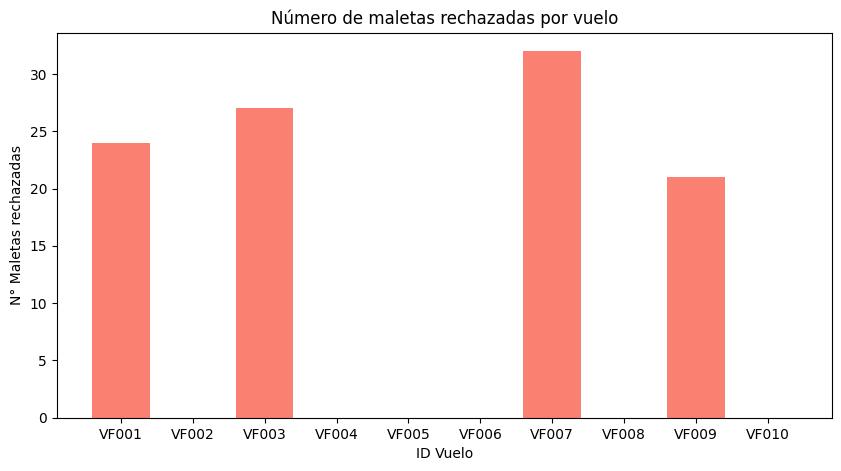

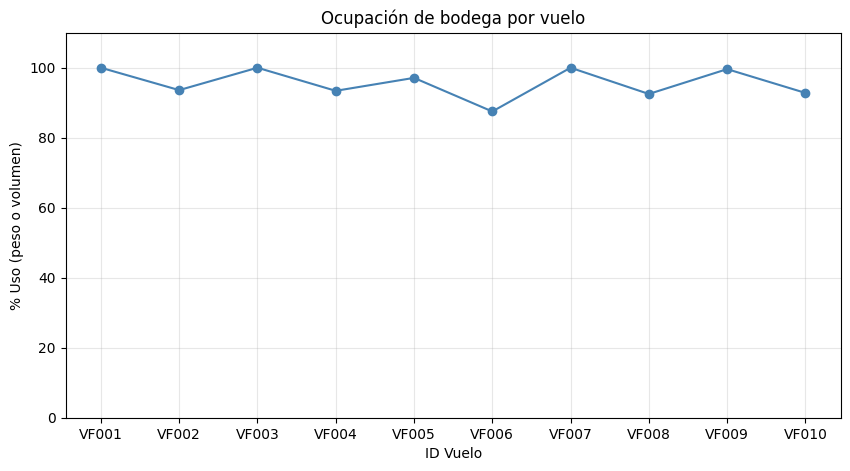

In [8]:
######
###### Resultados
######

print("####### Resumen por vuelo #######")
print(df_summary)

print("\n####### Historial de rechazos #######")
print(df_rejected.head())

print("\n####### Maletas que no lograron viajar en el día #######")
#print(df_not_flown.head())
print("\n n°", df_not_flown.shape[0])

######
###### Visualización de resultados
######

# Maletas rechazadas por vuelo
plt.figure(figsize=(10,5))
plt.bar(df_summary["flight_id"], df_summary["n_rejected"], color="salmon")
plt.title("Número de maletas rechazadas por vuelo")
plt.xlabel("ID Vuelo")
plt.ylabel("N° Maletas rechazadas")
plt.show()

# Porcentaje de ocupación de bodega por vuelo, ya sea por volumen o peso
df_summary["perc_capacity_used"] = df_summary[["perc_weight_used","perc_vol_used"]].max(axis=1)
plt.figure(figsize=(10,5))
plt.plot(df_summary["flight_id"], df_summary["perc_capacity_used"], marker="o", color="steelblue")
plt.title("Ocupación de bodega por vuelo")
plt.ylabel("% Uso (peso o volumen)")
plt.xlabel("ID Vuelo")
plt.ylim(0, 110)
plt.grid(alpha=0.3)
plt.show()

Este propotipo constituye un primer acercamiento exploratorio. Sin embargo, en un entorno real se podría mejorar de diversas formas, primero se podría incorporar información económica como el valor exacto del ticket, tarifas de equipaje extra, tarifas por exceso de peso o volumen, segundo, se podría usar programación lineal entera para maximizar ingresos o minimizar maletas rechazadas bajo restricciones de peso/volumen, tercero, dado que no todos los pasajeros confirmados llegan,se prodrían incorporar probabilidades de arribar mejorando la predicción de espacio disponible, cuarto para la visualización se implementarian dashboards en Power BI o Tableau para mostrar ocupación de bodega, maletas rechazadas o ingresos perdidos en tiempo real.